In [1]:
! pip install rdkit pysmiles prettytable pybel huggingface_hub ijson datasets

In [2]:
import typing_extensions
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import multiprocessing
from scipy import stats
import os, sys
import time
import json


start = time.time()

file_dir = os.path.dirname("../")
sys.path.append(file_dir)

from anima.smiles import SMILES

sml = SMILES()

cores = int(multiprocessing.cpu_count())
print(f"Cores: {cores}, GPUs: {torch.cuda.device_count()}")

database = pd.read_csv("../anima-master/databases/OMEAD_41801.csv", nrows=1000)

#train_db["gap"] = train_db.lumo - train_db.homo
#gap = np.array(train_db.gap)

# Read vocab from training
vocab_path = "Test1/vocab.dat"
print("\nReading vocabulary from file")
if os.path.isfile(vocab_path):
	vocab = []
	print("\nVocab file found\n")
	with open(vocab_path, "r") as f:
		Lines = f.readlines()
		for line in Lines:
			vocab.append(line.replace('\n', ''))
		f.close()

# Read max_length from training
with open("Test1/config.json", "r") as f:
    config = json.load(f)

max_length = config["max_length"]

# Filter out invalid smiles (exceeding max_length)
idx = database.index[database.smiles.apply(lambda sm: len(sml.smilesSEP(sm)) > max_length)]
train_db = database
train_db.drop(index=idx, inplace=True)
smiles = np.array(train_db.smiles)

#train_db["gap"] = train_db.lumo - train_db.homo
train_db["gap"] = train_db.lumo-train_db.homo
gap = np.array(train_db.gap)

# Preparing SMILES into SEQUENCES or 1h tensors
# for embeddings
all_sequences = []

l = 1
for i in smiles:
    print(l, end="\r")
    all_sequences.append(torch.tensor(sml.smilesToSequence(i, vocab)))
    l += 1


# for embeddings
packing = torch.nn.utils.rnn.pack_sequence(
        all_sequences,
        enforce_sorted=False
        )

packing_padding = torch.nn.utils.rnn.pad_packed_sequence(
        packing,
        batch_first=True,
        total_length=max_length
        )

# Check dimensions
# for embedding
# BATCH x SEQUENCE x INFO
print(f"\nCheck packing shape: {packing_padding[0][:,:,:].size()}\n")

temp = packing_padding[0][:,:,0].numpy()
x_test = temp
del temp

Cores: 64, GPUs: 1

Reading vocabulary from file

Vocab file found

1000
Check packing shape: torch.Size([1000, 224, 1])



In [3]:
class SMILESTransformerRegressor(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_heads, n_layers, hidden_dim, max_len, output_dim, dropout):
        super(SMILESTransformerRegressor, self).__init__()

        self.embeddings = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, embed_dim))

        # Transformer encoding
        encoder_layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=n_heads,
                dim_feedforward=hidden_dim,
                batch_first=True
                )

        self.transformer_encoder = nn.TransformerEncoder(
                encoder_layer,
                num_layers=n_layers)

        # Regression head
        self.fc = nn.Sequential(
                nn.Linear(embed_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
                )

    def forward(self, x):
         """
         x: Tensor of shape (batch_size, seq_len)
         """
         batch_size, seq_len = x.shape

         # Embed and add positional encoding
         x_embed = self.embeddings(x) # (batch size, seq_len, embed_dim)

         # If sequence is shorter than max_len, crop pos encoding
         pos_enc = self.positional_encoding[:, :seq_len, :].to(x.device) # (1, seq_len, embed_dim)
         x_embed = x_embed + pos_enc

         # Transformer expects input shape (batch_size, seq_len, embed_dim)
         x_transformed = self.transformer_encoder(x_embed)

         # Pooling: mean over sequence dimension
         x_pooled = x_transformed.mean(dim=1) # (batch_size, embed_dim)

         out = self.fc(x_pooled) # (batch_size, 1)
         return out.squeeze(1) # (batch_size, )

Cuda available: True
Batch: 0000016.00 of 0000015.62
Time to run script: 2.9221131801605225s



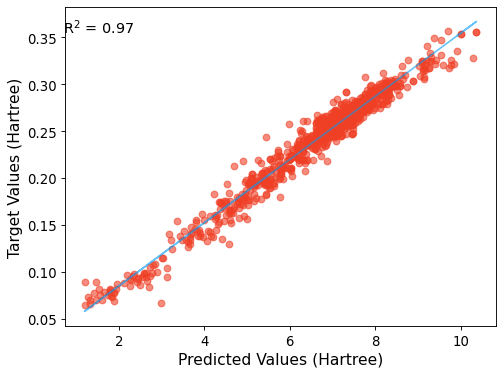

In [4]:
nn_gap = torch.load("Test1/nn_test.pt_full", weights_only=False)

# Checking CUDA
use_cuda = True
print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device(
    "cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

def model_predictions(model, x, device, batch_size = 64):
    # predictions

    model.eval().to(device)

    pred_data = TensorDataset(torch.tensor(x))
    pred_loader = DataLoader(
        pred_data,
        shuffle=False,
        batch_size=batch_size,
        drop_last=False,
    )

    batches = len(x) / batch_size

    with torch.no_grad():
        for batch_idx, data in enumerate(pred_loader):
            print(f"Batch: {batch_idx + 1:010.2f} of {batches:010.2f}", end="\r")
            inputs = data[0]
            inputs = inputs.to(device)

            #print(f"Inputs shape in prediction: {inputs.shape}")
            output = model(inputs)
            if batch_idx == 0:
                temp = output.cpu().detach().numpy()
            else:
                temp = np.append(temp, output.cpu().detach().numpy())
            del inputs, output

    return np.reshape(temp, -1)

predictions = model_predictions(nn_gap, x_test, device, batch_size=64)

px = predictions.reshape(-1) * 27.21
py = gap.reshape(-1)

# Generate linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(px, py)
line = slope * px + intercept
conf = std_err * 2.58  # 99% confidence interval

fig, axs = plt.subplots(1, 1, dpi=80)
axs.tick_params(axis="both", which="major", labelsize=12)

axs.plot(px, py, "o", color="xkcd:tomato", aa=True, alpha=0.6)
axs.plot(px, line, color="xkcd:azure", aa=True, alpha=0.6)

axs.set_ylabel(r"Target Values (Hartree)", fontsize=14)
axs.set_xlabel("Predicted Values (Hartree)", fontsize=14)
fig.text(0.13, 0.90, "R$^2$ = " + str(round(r_value**2, 2)), ha="left", fontsize=13)

fig.tight_layout()
plt.savefig("Pred_result.png", dpi=200)

stop = time.time()
print(f"\nTime to run script: {stop-start}s\n")

In [5]:
sorted_pred = np.sort(px)
type(sorted_pred)

numpy.ndarray

In [6]:
# Total number of parameters
total_params = sum(p.numel() for p in nn_gap.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 2,319,524
